# Idea
The idea is that we predict rotated linear dimension position from lines and text from the drawing.

# Thoughts
Basic logic is we split dataset to input lines or texts positions StartPoint, EndPoint, Position XYZ and predict dimension extension line poistion XLine1Point, XLine2Point XYZ.

We going to group samples by FileId. That is each sample will contain variable length data (attributes of variable number of  lines and text) and variable output data (variable number of dimensions).

I intend to [use RNN for it](https://medium.com/dair-ai/building-rnns-is-fun-with-pytorch-and-google-colab-3903ea9a3a79)

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline

In [2]:
# https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/
import torch
from torch import nn
from torch.utils.data import Dataset, SubsetRandomSampler
from torch.nn import functional as F

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
    
device

/home/mk/anaconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


device(type='cpu')

# Dataset implementation

In [3]:
from dataset import DwgDataset
batch_size = 2

dwg_dataset = DwgDataset(pickle_file = 'test_dataset.pickle', batch_size = batch_size)

train_loader = dwg_dataset.train_loader
val_loader   = dwg_dataset.val_loader
test_loader  = dwg_dataset.test_loader

ent_features = dwg_dataset.entities.ent_features
dim_features = dwg_dataset.entities.dim_features

In [4]:
for c,d in dwg_dataset.entities:
    # print(c.shape, d.shape)
    # make sure we have every training sample not empty
    assert( c.shape[0] != 0)    

In [5]:
(a,b) = next(iter(train_loader))
print(len(a),len(b))
for (x,y) in iter(train_loader):
    for xx in x:
        print(xx.shape)
        pass
    for yy in y:
        print(yy.shape)
    # print(a.shape,b.shape)
    break

2 2
torch.Size([990, 9])
torch.Size([603, 9])
torch.Size([1, 6])
torch.Size([259, 6])


# Model and training


In [6]:
from model import RnnDecoder, RnnEncoder
rnn_encoder = RnnEncoder(ent_features, 1024).to(device)
rnn_decoder = RnnDecoder(1024, dim_features).to(device)

In [7]:
(x,y) = next(iter(train_loader))
print('inputs','x:',len(x),'x',x[0].shape,'y:',len(y),'x',y[0].shape)
outs_numbers, learned = rnn_encoder(x)
print('learned shape:', learned.shape)
print("outs shape:", outs_numbers.shape, 'outs_value', outs_numbers)
# make sure something is passed
outs_numbers[0] = 42
decoded = rnn_decoder(outs_numbers, learned)
print('decoded:',len(decoded),'x', decoded[0].shape)

inputs x: 2 x torch.Size([1434, 9]) y: 2 x torch.Size([73, 6])
learned shape: torch.Size([2, 1024])
outs shape: torch.Size([2, 1]) outs_value tensor([[657.],
        [144.]], grad_fn=<CopySlices>)
decoded: 2 x torch.Size([42, 6])


In [8]:
%matplotlib inline
from train import train_model, plot_history

[0-0 @ 0.4 sec] Log10 Loss: 6.542550 Train err: 100.0%
[0-1 @ 3.6 sec] Log10 Loss: 6.418828 Train err: 100.0%
[0-2 @ 5.2 sec] Log10 Loss: 6.180330 Train err: 100.0%
[0-3 @ 16.8 sec] Log10 Loss: 3.699234 Train err: 100.0%
[0-4 @ 19.3 sec] Log10 Loss: 3.776604 Train err: 100.0%
[0-5 @ 19.9 sec] Log10 Loss: 2.896722 Train err: 100.0%
[0-6 @ 21.9 sec] Log10 Loss: 5.930169 Train err: 100.0%
[0-7 @ 24.7 sec] Log10 Loss: 5.931946 Train err: 100.0%
[0-8 @ 25.7 sec] Log10 Loss: 5.968882 Train err: 100.0%
[0-9 @ 26.7 sec] Log10 Loss: 2.930624 Train err: 100.0%
[0-10 @ 27.1 sec] Log10 Loss: 0.689089 Train err: 100.0%
Epoch validation accuracy: 0.000
[1-0 @ 43.1 sec] Log10 Loss: 3.734160 Train err: 100.0%
[1-1 @ 43.8 sec] Log10 Loss: 6.180071 Train err: 100.0%
[1-2 @ 46.6 sec] Log10 Loss: 6.550810 Train err: 100.0%
[1-3 @ 49.3 sec] Log10 Loss: 1.601631 Train err: 100.0%
[1-4 @ 50.4 sec] Log10 Loss: 5.888942 Train err: 100.0%
[1-5 @ 54.0 sec] Log10 Loss: 6.285167 Train err: 100.0%
[1-6 @ 55.8 sec] 

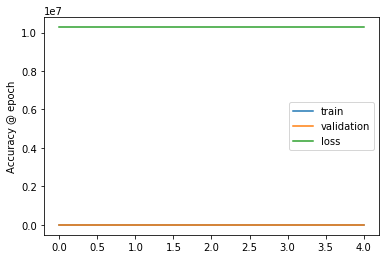

In [9]:
lr = 3e-4
epochs = 5
decoder_optimizer = torch.optim.Adam(rnn_decoder.parameters(), lr = lr)
encoder_optimizer = torch.optim.Adam(rnn_encoder.parameters(), lr = lr)
from chamfer_distance_loss import MyChamferDistance
loss = MyChamferDistance()

loss_history, train_history, val_history = train_model(
    encoder = rnn_encoder, 
    decoder = rnn_decoder, 
    train_loader = train_loader,
    val_loader = val_loader,
    loss = loss,
    decoder_opt = decoder_optimizer,
    encoder_opt = encoder_optimizer,
    epochs = epochs)

plot_history(loss_history, train_history, val_history)

In [10]:
from train import calculate_accuracy
i = 0
for (x, y) in iter(val_loader):
    outs, learned = rnn_encoder(x)
    decoded = rnn_decoder(outs, learned)
    
    yyy = []
    for yy in y:
        yyy.append(yy.shape[0])
    ppp = []
    for dd in decoded:
        ppp.append(dd.shape[0])
    
    print('yyy', yyy)
    print('prd', ppp)
    
    lv = loss(decoded, y)
    print ('loss', lv)

    acc = calculate_accuracy(decoded, y)
    print('acc', acc)

    i += 1
    print(i, '------------------------------')

yyy [100, 3]
prd [9, 1032]
loss tensor([80943.5625], grad_fn=<AddBackward0>)
acc [0, 0]
1 ------------------------------
yyy [0, 0]
prd [468, 618]
loss tensor([9.4686], grad_fn=<AddBackward0>)
acc [0, 0]
2 ------------------------------
yyy [0]
prd [55]
loss tensor([4.7155], grad_fn=<AddBackward0>)
acc [0]
3 ------------------------------


In [11]:
ii = pd.DataFrame(x[0].cpu().detach().numpy())
print(ii.head())
yy = pd.DataFrame(y[0].cpu().detach().numpy())
print(len(yy))
print(yy.head())
pp = pd.DataFrame(prediction[0].cpu().detach().numpy())
print(len(pp))
print(pp.head())

              0             1             2             3             4  \
0  46846.722656 -30300.000000 -4.108182e-18  -4841.409668 -3.030000e+04   
1  34800.000000   3853.695068 -1.170912e-17  34800.000000 -3.378169e+04   
2  46846.722656      0.000003  8.563584e-17  -4841.409668 -9.921496e-08   
3   9900.000000 -21900.000000  1.835710e-16  -4841.409668 -2.190000e+04   
4  46846.722656 -23100.000000  1.835834e-16  19200.000000 -2.310000e+04   

              5    6    7    8  
0 -1.169877e-17  0.0  0.0  0.0  
1  9.589572e-17  0.0  0.0  0.0  
2 -1.169877e-17  0.0  0.0  0.0  
3 -1.169877e-17  0.0  0.0  0.0  
4  1.835834e-16  0.0  0.0  0.0  
0
Empty DataFrame
Columns: [0, 1, 2, 3, 4, 5]
Index: []


NameError: name 'prediction' is not defined

In [12]:
from train import calculate_accuracy
torch.cuda.empty_cache()

rnn_encoder.eval()
rnn_decoder.eval()

test_accuracies = []
for (x,y) in test_loader:
    with torch.no_grad():
        out, hidden = rnn_encoder(x)
        prediction = rnn_decoder(out, hidden)
        accuracy = calculate_accuracy(prediction, y)
        test_accuracies.append(accuracy)
        
mean_test_accuracy = np.mean(test_accuracies)
print('Accuracy on testing: {0:2.3f}'.format(mean_test_accuracy))

TypeError: unsupported operand type(s) for /: 'list' and 'int'